In [2]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import tqdm
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.distributions import Categorical

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

In [3]:
NUM_EPISODES = 10000
MAX_STEPS = 500
SOLVED_SCORE = 490

GAMMA = 0.99
HIDDEN_UNITS = 256
LR_ACTOR = 0.0005
LR_CRITIC = 0.0005
N_STEPS = 3

#device to run model on 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


In [15]:
class Actor(nn.Module):    
    def __init__(self, observation_space, hidden_units, action_space):
        super(Actor, self).__init__()
        self.input_layer = nn.Linear(observation_space, hidden_units)
        self.output_layer = nn.Linear(hidden_units, action_space)
    
    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        actions = self.output_layer(x)
        action_probs = F.softmax(actions, dim=1)
        return action_probs

In [16]:
class Critic(nn.Module):
    def __init__(self, observation_space, hidden_units):
        super(Critic, self).__init__()
        self.input_layer = nn.Linear(observation_space, hidden_units)
        self.output_layer = nn.Linear(hidden_units, 1)
        
    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        state_value = self.output_layer(x)
        return state_value

In [17]:
env = gym.make('CartPole-v1')

observation_space = env.observation_space.shape[0]
action_space = env.action_space.n
hidden_units = HIDDEN_UNITS

actor = Actor(observation_space, hidden_units, action_space).to(DEVICE)
critic = Critic(observation_space, hidden_units).to(DEVICE)

actor_optimizer = torch.optim.Adam(actor.parameters(), lr=LR_ACTOR)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=LR_CRITIC)

In [18]:
def select_action(actor, state):
    ''' Selects an action given current state using the actor network.'''
    
    #convert state to float tensor, add 1 dimension, allocate tensor on device
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    
    #use network to predict action probabilities
    action_probs = actor(state)
    state = state.detach()
    
    #sample an action using the probability distribution
    m = Categorical(action_probs)
    action = m.sample()
    
    #return action
    return action.item(), m.log_prob(action)

In [7]:
# recent_states = deque(maxlen=N_STEPS)
# recent_states.append(1)
# recent_states.append(2)
# recent_states.append(3)
# recent_states.append(4)
# len(recent_states)
# print(recent_states)
# for s in recent_states:
#     print(s)

deque([2, 3, 4], maxlen=3)
2
3
4


In [19]:
#track scores
scores = []

#track recent scores
recent_scores = deque(maxlen = 100)

#run episodes
for episode in tqdm.trange(NUM_EPISODES):
    
    #init variables
    state, _ = env.reset()
    
    #track eligibility traces
    z_theta = None
    z_w = None

    done = False
    score = 0
    I = 1
    
    #run episode, update online
    for step in range(MAX_STEPS):
        
        #get action and log probability
        action, lp = select_action(actor, state)
        
        #step with action
        new_state, reward, done, _, _ = env.step(action)
        
        #update episode score
        score += reward
        
        #get state value of current state
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        state_val = critic(state_tensor)
        
        #get state value of next state
        new_state_tensor = torch.from_numpy(new_state).float().unsqueeze(0).to(DEVICE)        
        new_state_val = critic(new_state_tensor)
        
        #if terminal state, next state val is 0
        if done:
            new_state_val = torch.tensor([0]).float().unsqueeze(0).to(DEVICE)

        target = reward + GAMMA * new_state_val
        if z_w == None:
            z_w = state_val
        else:
            z_w += GAMMA * z_w + state_val
        
        #calculate value function loss with MSE
        val_loss = F.smooth_l1_loss(reward + GAMMA * new_state_val, state_val)
        val_loss *= I
        
        #calculate policy loss
        advantage = reward + GAMMA * new_state_val.item() - state_val.item()
        actor_loss = -lp * advantage
        actor_loss *= I
        
        #Backpropagate actor
        actor_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        actor_optimizer.step()
        
        #Backpropagate critic
        critic_optimizer.zero_grad()
        val_loss.backward()
        critic_optimizer.step()
        
        if done:
            break
            
        #move into new state, discount I
        state = new_state
        I *= GAMMA
    
    #append episode score 
    scores.append(score)
    recent_scores.append(score)

    #print episode stats
    if episode % 100 == 0:
        print('Episode {}\tAverage Score: {:.2f}'.format(episode, np.array(recent_scores).mean()))
    
    #early stopping if we meet solved score goal
    if np.array(recent_scores).mean() >= SOLVED_SCORE:
        break

  0%|          | 0/10000 [00:00<?, ?it/s]

Episode 0	Average Score: 21.00


  0%|          | 2/10000 [00:00<12:05, 13.78it/s]

  1%|          | 103/10000 [00:09<16:18, 10.11it/s]

Episode 100	Average Score: 34.87


  2%|▏         | 201/10000 [00:26<36:37,  4.46it/s]

Episode 200	Average Score: 58.33


  3%|▎         | 301/10000 [00:43<1:16:33,  2.11it/s]

Episode 300	Average Score: 64.27


  4%|▍         | 401/10000 [01:16<1:15:22,  2.12it/s]

Episode 400	Average Score: 126.64


  5%|▌         | 505/10000 [01:46<05:23, 29.38it/s]  

Episode 500	Average Score: 114.94


  6%|▌         | 601/10000 [01:51<14:19, 10.94it/s]

Episode 600	Average Score: 18.82


  7%|▋         | 692/10000 [03:24<3:50:50,  1.49s/it]

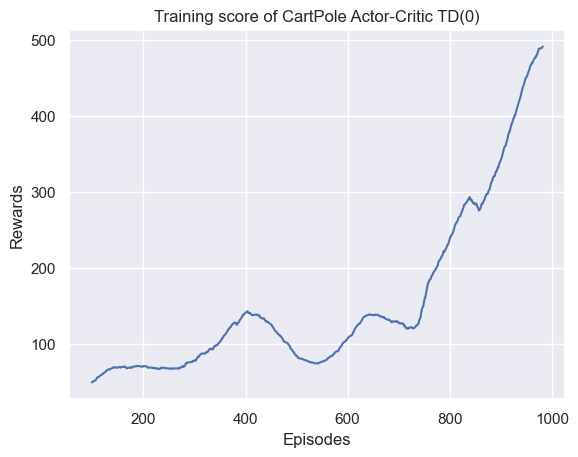

In [ ]:
sns.set()
scores_series = pd.Series(scores)
rolling_average = scores_series.rolling(window=100).mean()
plt.plot(rolling_average)
plt.ylabel('Rewards')
plt.xlabel('Episodes')
plt.title('Training score of CartPole Actor-Critic TD(0)')
plt.show()

In [ ]:
done = False
state = env.reset()
scores = []

for _ in tqdm.trange(50):
    state, _ = env.reset()
    done = False
    trunc = False
    score = 0
    while not done and not trunc:
        action, lp = select_action(actor, state)
        new_state, reward, done, trunc, _ = env.step(action)
        score += reward
        state = new_state
    scores.append(score)
env.close()

100%|██████████| 50/50 [00:09<00:00,  5.17it/s]


In [ ]:
mean_score = np.array(scores).mean()
print('Mean score: ', mean_score)

Mean score:  500.0


In [ ]:
state, _ = env.reset()
done = False
trunc = False
score = 0
while not done and not trunc:
    action, lp = select_action(actor, state)
    new_state, reward, done, trunc, _ = env.step(action)
    score += reward
    state = new_state
scores.append(score)

In [ ]:
# test model agent
env = gym.make('CartPole-v1', render_mode="rgb_array")
frames = [] 
done = False
trunc = False
score = 0
state, _ = env.reset()
while not done and not trunc:
    action, lp = select_action(actor, state)
    new_state, reward, done, trunc, _ = env.step(action)
    score += reward
    state = new_state
    img = env.render()
    frames.append(img)

print("Score:", score)
imageio.mimsave('cartpole-actor_critic.gif', frames, duration=60)

Score: 500.0
